#### BERT Sequence Classifier Reference Blogpost 
https://towardsdatascience.com/text-classification-with-bert-in-pytorch-887965e5820f

In [1]:
!pip install -U torch==1.9.0

  Using cached torch-1.9.0-cp38-none-macosx_11_0_arm64.whl (41.5 MB)
  Attempting uninstall: torch
    Found existing installation: torch 1.14.0.dev20221115
    Uninstalling torch-1.14.0.dev20221115:
      Successfully uninstalled torch-1.14.0.dev20221115


In [2]:
!pip install transformers

In [3]:
!pip install pickle5

In [4]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
from transformers import BertTokenizer, BertForSequenceClassification, BertModel
import torch.optim as optim
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import pickle5 as pkl
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch.optim import Adam
from tqdm import tqdm
from sklearn.utils.class_weight import compute_class_weight

In [5]:
train_dataset_path = "tos_clauses_train.csv"
test_dataset_path = "tos_clauses_dev.csv"
train_df = pd.read_csv(train_dataset_path, header=0)
test_df = pd.read_csv(test_dataset_path, header=0)

In [6]:
def read_embeddings():
    train_avg_embeddings_file_path = "train_avg_embeddings.pkl"
    with open(train_avg_embeddings_file_path, mode="rb") as train_file:
        train_data = pkl.load(train_file) 
    test_avg_embeddings_file_path = "test_avg_embeddings.pkl"
    with open(test_avg_embeddings_file_path, mode="rb") as test_file:
        test_data = pkl.load(test_file) 
    return train_data, test_data

train_data, test_data = read_embeddings()


In [7]:
df_train = pd.DataFrame(train_data)
df_train["embeddings"] = df_train.values.tolist()
df_train = df_train[["embeddings"]]
df_train["label"] = train_df["label"]

In [8]:
df_test = pd.DataFrame(test_data)
df_test["embeddings"] = df_test.values.tolist()
df_test = df_test[["embeddings"]]
df_test["label"] = test_df["label"]
df_test.head(1)

,embeddings,label
0,"[0.13353028893470764, 0.7151040434837341, 0.25...",0


In [9]:
class TensorDataset(Dataset):
    def __init__(self, dataframe):
        self.data = dataframe

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        features = np.array(self.data.loc[index, 'embeddings'])
        label = int(self.data.loc[index, 'label'])
        return torch.from_numpy(features).float(), label
    
    def __getindexlist__(self):
        return list(self.data.index.values)

work_train = df_train.copy()
work_test = df_test.copy()
X_train_tensor = TensorDataset(work_train)
X_test_tensor = TensorDataset(work_test)

num_of_workers = 0
batch_size = 20
valid_size = 0.2

num_train = len(X_train_tensor)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

print(len(train_idx))
print(len(valid_idx))
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

train_loader = torch.utils.data.DataLoader(X_train_tensor, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_of_workers, drop_last=True)
valid_loader = torch.utils.data.DataLoader(X_train_tensor, batch_size=batch_size, 
    sampler=valid_sampler, num_workers=num_of_workers, drop_last=True)
test_loader = torch.utils.data.DataLoader(X_test_tensor, batch_size=batch_size, 
    num_workers=num_of_workers, drop_last=True)

6025
1506


In [10]:
train_df_by_index = work_train.loc[train_idx]
val_df_by_index = work_train.loc[valid_idx]
train_fair = sum(train_df_by_index['label'] == 0)
train_unfair = sum(train_df_by_index['label'] == 1)
val_fair = sum(val_df_by_index['label'] == 0)
val_unfair = sum(val_df_by_index['label'] == 1)

print("train_fair:" + str(train_fair))
print("train_unfair:" + str(train_unfair))
print("val_fair:" + str(val_fair))
print("val_unfair:" + str(val_unfair))

train_fair:5374
train_unfair:651
val_fair:1331
val_unfair:175


In [11]:
class BertClassifier(nn.Module):

    def __init__(self, dropout=0.5):

        super(BertClassifier, self).__init__()

        self.bert = BertModel.from_pretrained('bert-base-cased')
        self.dropout = nn.Dropout(dropout)
        self.linear_1 = nn.Linear(768, 512)
        self.relu = nn.ReLU()
        self.linear_2 = nn.Linear(512, 10)
        self.relu = nn.ReLU()
        self.linear_3 = nn.Linear(10, 2)
        self.relu = nn.ReLU()

    def forward(self, inputs_embeds):

        _, pooled_output = self.bert(inputs_embeds = inputs_embeds,return_dict=False)
        dropout_output = self.dropout(pooled_output)
        linear_output_1 = F.relu(self.linear_1(dropout_output))
        linear_output_2 = F.relu(self.linear_2(linear_output_1))
        final_layer = F.relu(self.linear_3(linear_output_2))
        return final_layer

In [ ]:
y = torch.FloatTensor(df_train.label.tolist())
class_weights=compute_class_weight('balanced',classes=np.unique(y),y=y.numpy())
class_weights=torch.tensor(class_weights,dtype=torch.float)
class_weights

In [12]:
def train(model, train_dataloader, val_dataloader, learning_rate, epochs, train_idx, val_idx):
    criterion = nn.CrossEntropyLoss(weight = torch.FloatTensor([1/train_fair, 1/train_unfair]))
    optimizer = Adam(model.parameters(), lr= learning_rate)
    epoch_nums_list = []
    train_loss_list = []
    val_loss_list = []
    for epoch_num in range(epochs):
        print("Epoch: " + str(epoch_num))
        total_acc_train = 0
        total_loss_train = 0

        for train_input, train_label in tqdm(train_dataloader):
            train_input = torch.reshape(train_input, (20, 1, 768))
            output = model(train_input)
                
            batch_loss = criterion(output, train_label.long())
            total_loss_train += batch_loss.item()
                
            acc = (output.argmax(dim=1) == train_label).sum().item()
            total_acc_train += acc

            model.zero_grad()
            batch_loss.backward()
            optimizer.step()
            
        total_acc_val = 0
        total_loss_val = 0

        with torch.no_grad():

            for val_input, val_label in val_dataloader:
                val_input = torch.reshape(val_input, (20, 1, 768))
                output = model(val_input)

                batch_loss = criterion(output, val_label.long())
                total_loss_val += batch_loss.item()
                    
                acc = (output.argmax(dim=1) == val_label).sum().item()
                total_acc_val += acc
            
        print(
                f'Epochs: {epoch_num} | Train Loss: {total_loss_train / len(train_idx): .3f} \
                | Train Accuracy: {total_acc_train / len(train_idx): .3f} \
                | Val Loss: {total_loss_val / len(val_idx): .3f} \
                | Val Accuracy: {total_acc_val / len(val_idx): .3f}')
        epoch_nums_list.append(epoch_num)
        train_loss_list.append(1- (total_acc_train / len(train_idx)))
        val_loss_list.append(1- (total_acc_val / len(val_idx)))
        if epoch_num in [1, 5, 10, 15, 20, 30, 40, 50]:
            torch.save(model.state_dict(), "bert_mod_avg_models/" + "bmod_" + str(epoch_num) + "_file.pt")
    return epoch_nums_list, train_loss_list, val_loss_list
EPOCHS = 50
model = BertClassifier()
LR = 1e-6
              
epoch_nums_list, train_loss_list, val_loss_list = train(model, train_loader, valid_loader, LR, EPOCHS, train_idx, valid_idx)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
  0%|                                                   | 0/301 [00:00<?, ?it/s]

Epoch: 0


  0%|                                                   | 0/301 [00:00<?, ?it/s]

Epochs: 0 | Train Loss:  0.034                 | Train Accuracy:  0.713                 | Val Loss:  0.034                 | Val Accuracy:  0.825
Epoch: 1


100%|█████████████████████████████████████████| 301/301 [01:11<00:00,  4.23it/s]


Epochs: 1 | Train Loss:  0.034                 | Train Accuracy:  0.743                 | Val Loss:  0.033                 | Val Accuracy:  0.648


  0%|                                                   | 0/301 [00:00<?, ?it/s]

Epoch: 2


  0%|                                                   | 0/301 [00:00<?, ?it/s]

Epochs: 2 | Train Loss:  0.033                 | Train Accuracy:  0.766                 | Val Loss:  0.033                 | Val Accuracy:  0.790
Epoch: 3


  0%|                                                   | 0/301 [00:00<?, ?it/s]

Epochs: 3 | Train Loss:  0.033                 | Train Accuracy:  0.745                 | Val Loss:  0.032                 | Val Accuracy:  0.799
Epoch: 4


  0%|                                                   | 0/301 [00:00<?, ?it/s]

Epochs: 4 | Train Loss:  0.033                 | Train Accuracy:  0.763                 | Val Loss:  0.032                 | Val Accuracy:  0.602
Epoch: 5


100%|█████████████████████████████████████████| 301/301 [01:11<00:00,  4.20it/s]


Epochs: 5 | Train Loss:  0.032                 | Train Accuracy:  0.744                 | Val Loss:  0.032                 | Val Accuracy:  0.546


  0%|                                                   | 0/301 [00:00<?, ?it/s]

Epoch: 6


  0%|                                                   | 0/301 [00:00<?, ?it/s]

Epochs: 6 | Train Loss:  0.032                 | Train Accuracy:  0.742                 | Val Loss:  0.032                 | Val Accuracy:  0.830
Epoch: 7


  0%|                                                   | 0/301 [00:00<?, ?it/s]

Epochs: 7 | Train Loss:  0.031                 | Train Accuracy:  0.775                 | Val Loss:  0.033                 | Val Accuracy:  0.849
Epoch: 8


  0%|                                                   | 0/301 [00:00<?, ?it/s]

Epochs: 8 | Train Loss:  0.031                 | Train Accuracy:  0.757                 | Val Loss:  0.031                 | Val Accuracy:  0.787
Epoch: 9


  0%|                                                   | 0/301 [00:00<?, ?it/s]

Epochs: 9 | Train Loss:  0.031                 | Train Accuracy:  0.763                 | Val Loss:  0.031                 | Val Accuracy:  0.788
Epoch: 10


100%|█████████████████████████████████████████| 301/301 [01:11<00:00,  4.18it/s]


Epochs: 10 | Train Loss:  0.030                 | Train Accuracy:  0.780                 | Val Loss:  0.030                 | Val Accuracy:  0.684


  0%|                                                   | 0/301 [00:00<?, ?it/s]

Epoch: 11


  0%|                                                   | 0/301 [00:00<?, ?it/s]

Epochs: 11 | Train Loss:  0.030                 | Train Accuracy:  0.788                 | Val Loss:  0.031                 | Val Accuracy:  0.766
Epoch: 12


  0%|                                                   | 0/301 [00:00<?, ?it/s]

Epochs: 12 | Train Loss:  0.030                 | Train Accuracy:  0.777                 | Val Loss:  0.030                 | Val Accuracy:  0.780
Epoch: 13


  0%|                                                   | 0/301 [00:00<?, ?it/s]

Epochs: 13 | Train Loss:  0.029                 | Train Accuracy:  0.786                 | Val Loss:  0.030                 | Val Accuracy:  0.749
Epoch: 14


  0%|                                                   | 0/301 [00:00<?, ?it/s]

Epochs: 14 | Train Loss:  0.029                 | Train Accuracy:  0.791                 | Val Loss:  0.030                 | Val Accuracy:  0.793
Epoch: 15


100%|█████████████████████████████████████████| 301/301 [01:12<00:00,  4.13it/s]


Epochs: 15 | Train Loss:  0.028                 | Train Accuracy:  0.791                 | Val Loss:  0.030                 | Val Accuracy:  0.800


  0%|                                                   | 0/301 [00:00<?, ?it/s]

Epoch: 16


  0%|                                                   | 0/301 [00:00<?, ?it/s]

Epochs: 16 | Train Loss:  0.028                 | Train Accuracy:  0.811                 | Val Loss:  0.030                 | Val Accuracy:  0.654
Epoch: 17


  0%|                                                   | 0/301 [00:00<?, ?it/s]

Epochs: 17 | Train Loss:  0.027                 | Train Accuracy:  0.817                 | Val Loss:  0.029                 | Val Accuracy:  0.729
Epoch: 18


  0%|                                                   | 0/301 [00:00<?, ?it/s]

Epochs: 18 | Train Loss:  0.027                 | Train Accuracy:  0.810                 | Val Loss:  0.029                 | Val Accuracy:  0.789
Epoch: 19


  0%|                                                   | 0/301 [00:00<?, ?it/s]

Epochs: 19 | Train Loss:  0.026                 | Train Accuracy:  0.832                 | Val Loss:  0.029                 | Val Accuracy:  0.787
Epoch: 20


100%|█████████████████████████████████████████| 301/301 [01:17<00:00,  3.87it/s]


Epochs: 20 | Train Loss:  0.026                 | Train Accuracy:  0.835                 | Val Loss:  0.029                 | Val Accuracy:  0.710


  0%|                                                   | 0/301 [00:00<?, ?it/s]

Epoch: 21


  0%|                                                   | 0/301 [00:00<?, ?it/s]

Epochs: 21 | Train Loss:  0.026                 | Train Accuracy:  0.815                 | Val Loss:  0.027                 | Val Accuracy:  0.778
Epoch: 22


  0%|                                                   | 0/301 [00:00<?, ?it/s]

Epochs: 22 | Train Loss:  0.025                 | Train Accuracy:  0.826                 | Val Loss:  0.029                 | Val Accuracy:  0.766
Epoch: 23


  0%|                                                   | 0/301 [00:00<?, ?it/s]

Epochs: 23 | Train Loss:  0.024                 | Train Accuracy:  0.842                 | Val Loss:  0.028                 | Val Accuracy:  0.790
Epoch: 24


  0%|                                                   | 0/301 [00:00<?, ?it/s]

Epochs: 24 | Train Loss:  0.024                 | Train Accuracy:  0.834                 | Val Loss:  0.029                 | Val Accuracy:  0.806
Epoch: 25


  0%|                                                   | 0/301 [00:00<?, ?it/s]

Epochs: 25 | Train Loss:  0.024                 | Train Accuracy:  0.849                 | Val Loss:  0.029                 | Val Accuracy:  0.767
Epoch: 26


  0%|                                                   | 0/301 [00:00<?, ?it/s]

Epochs: 26 | Train Loss:  0.023                 | Train Accuracy:  0.856                 | Val Loss:  0.029                 | Val Accuracy:  0.838
Epoch: 27


  0%|                                                   | 0/301 [00:00<?, ?it/s]

Epochs: 27 | Train Loss:  0.022                 | Train Accuracy:  0.860                 | Val Loss:  0.029                 | Val Accuracy:  0.831
Epoch: 28


  0%|                                                   | 0/301 [00:00<?, ?it/s]

Epochs: 28 | Train Loss:  0.021                 | Train Accuracy:  0.866                 | Val Loss:  0.029                 | Val Accuracy:  0.808
Epoch: 29


  0%|                                                   | 0/301 [00:00<?, ?it/s]

Epochs: 29 | Train Loss:  0.021                 | Train Accuracy:  0.860                 | Val Loss:  0.029                 | Val Accuracy:  0.822
Epoch: 30


100%|█████████████████████████████████████████| 301/301 [01:18<00:00,  3.85it/s]


Epochs: 30 | Train Loss:  0.021                 | Train Accuracy:  0.868                 | Val Loss:  0.029                 | Val Accuracy:  0.806


  0%|                                                   | 0/301 [00:00<?, ?it/s]

Epoch: 31


  0%|                                                   | 0/301 [00:00<?, ?it/s]

Epochs: 31 | Train Loss:  0.020                 | Train Accuracy:  0.871                 | Val Loss:  0.031                 | Val Accuracy:  0.851
Epoch: 32


  0%|                                                   | 0/301 [00:00<?, ?it/s]

Epochs: 32 | Train Loss:  0.019                 | Train Accuracy:  0.878                 | Val Loss:  0.030                 | Val Accuracy:  0.834
Epoch: 33


  0%|                                                   | 0/301 [00:00<?, ?it/s]

Epochs: 33 | Train Loss:  0.019                 | Train Accuracy:  0.888                 | Val Loss:  0.030                 | Val Accuracy:  0.817
Epoch: 34


  0%|                                                   | 0/301 [00:00<?, ?it/s]

Epochs: 34 | Train Loss:  0.018                 | Train Accuracy:  0.891                 | Val Loss:  0.030                 | Val Accuracy:  0.776
Epoch: 35


  0%|                                                   | 0/301 [00:00<?, ?it/s]

Epochs: 35 | Train Loss:  0.017                 | Train Accuracy:  0.896                 | Val Loss:  0.033                 | Val Accuracy:  0.863
Epoch: 36


  0%|                                                   | 0/301 [00:00<?, ?it/s]

Epochs: 36 | Train Loss:  0.017                 | Train Accuracy:  0.900                 | Val Loss:  0.029                 | Val Accuracy:  0.770
Epoch: 37


  0%|                                                   | 0/301 [00:00<?, ?it/s]

Epochs: 37 | Train Loss:  0.016                 | Train Accuracy:  0.906                 | Val Loss:  0.031                 | Val Accuracy:  0.843
Epoch: 38


  0%|                                                   | 0/301 [00:00<?, ?it/s]

Epochs: 38 | Train Loss:  0.017                 | Train Accuracy:  0.882                 | Val Loss:  0.029                 | Val Accuracy:  0.805
Epoch: 39


  0%|                                                   | 0/301 [00:00<?, ?it/s]

Epochs: 39 | Train Loss:  0.015                 | Train Accuracy:  0.906                 | Val Loss:  0.032                 | Val Accuracy:  0.841
Epoch: 40


100%|█████████████████████████████████████████| 301/301 [01:17<00:00,  3.88it/s]


Epochs: 40 | Train Loss:  0.015                 | Train Accuracy:  0.914                 | Val Loss:  0.033                 | Val Accuracy:  0.836


  0%|                                                   | 0/301 [00:00<?, ?it/s]

Epoch: 41


  0%|                                                   | 0/301 [00:00<?, ?it/s]

Epochs: 41 | Train Loss:  0.014                 | Train Accuracy:  0.915                 | Val Loss:  0.034                 | Val Accuracy:  0.841
Epoch: 42


  0%|                                                   | 0/301 [00:00<?, ?it/s]

Epochs: 42 | Train Loss:  0.014                 | Train Accuracy:  0.921                 | Val Loss:  0.032                 | Val Accuracy:  0.814
Epoch: 43


  0%|                                                   | 0/301 [00:00<?, ?it/s]

Epochs: 43 | Train Loss:  0.014                 | Train Accuracy:  0.918                 | Val Loss:  0.037                 | Val Accuracy:  0.868
Epoch: 44


  0%|                                                   | 0/301 [00:00<?, ?it/s]

Epochs: 44 | Train Loss:  0.013                 | Train Accuracy:  0.925                 | Val Loss:  0.034                 | Val Accuracy:  0.845
Epoch: 45


  0%|                                                   | 0/301 [00:00<?, ?it/s]

Epochs: 45 | Train Loss:  0.013                 | Train Accuracy:  0.924                 | Val Loss:  0.033                 | Val Accuracy:  0.790
Epoch: 46


  0%|                                                   | 0/301 [00:00<?, ?it/s]

Epochs: 46 | Train Loss:  0.012                 | Train Accuracy:  0.929                 | Val Loss:  0.035                 | Val Accuracy:  0.851
Epoch: 47


  0%|                                                   | 0/301 [00:00<?, ?it/s]

Epochs: 47 | Train Loss:  0.012                 | Train Accuracy:  0.934                 | Val Loss:  0.037                 | Val Accuracy:  0.843
Epoch: 48


  0%|                                                   | 0/301 [00:00<?, ?it/s]

Epochs: 48 | Train Loss:  0.012                 | Train Accuracy:  0.924                 | Val Loss:  0.035                 | Val Accuracy:  0.791
Epoch: 49


100%|█████████████████████████████████████████| 301/301 [01:17<00:00,  3.89it/s]


Epochs: 49 | Train Loss:  0.011                 | Train Accuracy:  0.940                 | Val Loss:  0.039                 | Val Accuracy:  0.863


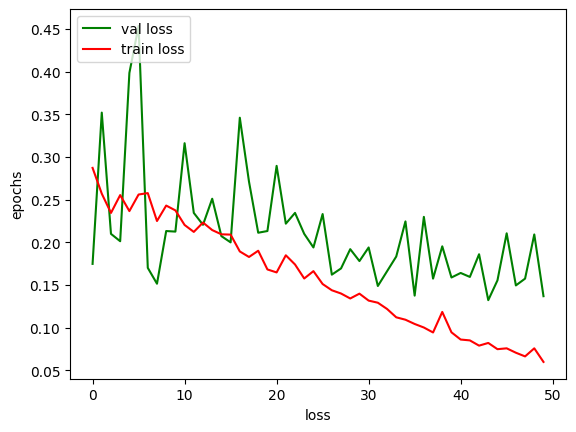

In [13]:
plt.plot(epoch_nums_list, val_loss_list, color = 'green', label = 'val loss')
plt.plot(epoch_nums_list, train_loss_list, color = 'red', label = 'train loss')
plt.legend(loc = 'upper left')
plt.ylabel('epochs')
plt.xlabel('loss')
plt.show()

In [14]:
def evaluate(model, test_dataloader, test_data):
    prediction_list = []
    actual_list = []
    total_acc_test = 0
    with torch.no_grad():

        for test_input, test_label in test_dataloader:
            test_input = torch.reshape(test_input, (len(test_data), 1, 768))
            output = model(test_input)
            acc = (output.argmax(dim=1) == test_label).sum().item()
            total_acc_test += acc
            _, predicted = torch.max(output.data, 1) 
            prediction_list.append(predicted)
            actual_list.append(test_label)
    
    print(f'Test Accuracy: {total_acc_test / len(test_data): .3f}')
    
    return prediction_list[0].tolist(), actual_list[0].tolist()

test_loader = torch.utils.data.DataLoader(X_test_tensor, batch_size=len(df_test), num_workers=num_of_workers, drop_last=True)
prediction_list, actual_list = evaluate(model, test_loader, df_test)
report = classification_report(actual_list, prediction_list, output_dict=True)
report

Test Accuracy:  0.865


{'0': {'precision': 0.9197166469893743,
  'recall': 0.9290399522957663,
  'f1-score': 0.9243547908632455,
  'support': 1677},
 '1': {'precision': 0.37037037037037035,
  'recall': 0.33980582524271846,
  'f1-score': 0.35443037974683544,
  'support': 206},
 'accuracy': 0.8645778013807753,
 'macro avg': {'precision': 0.6450435086798723,
  'recall': 0.6344228887692424,
  'f1-score': 0.6393925853050404,
  'support': 1883},
 'weighted avg': {'precision': 0.85961822267524,
  'recall': 0.8645778013807753,
  'f1-score': 0.8620051208207704,
  'support': 1883}}

In [15]:
from tabulate import tabulate
import os 

def evaluate(test_dataloader, test_data):
    #bert_sc_avg_models
    path = "bert_mod_avg_models/"
    files = os.listdir("./bert_mod_avg_models/")
    for file in files:
        print("Model Epoch: " + file)
        curr_model = BertClassifier()

        curr_model.load_state_dict(torch.load(path + file))
        prediction_list = []
        actual_list = []
        total_acc_test = 0
        
        with torch.no_grad():

            for test_input, test_label in test_dataloader:
                test_input = torch.reshape(test_input, (len(test_data), 1, 768))
                output = curr_model(test_input)
                acc = (output.argmax(dim=1) == test_label).sum().item()
                total_acc_test += acc
                _, predicted = torch.max(output.data, 1) 
                prediction_list.append(predicted)
                actual_list.append(test_label)
    
        print(f'Test Accuracy: {total_acc_test / len(test_data): .3f}')
        report = classification_report(actual_list[0].tolist(), prediction_list[0].tolist())
        print(report)

test_loader = torch.utils.data.DataLoader(X_test_tensor, batch_size=len(df_test), num_workers=num_of_workers, drop_last=True)
evaluate(test_loader, df_test)

Model Epoch: bmod_1_file.pt


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Test Accuracy:  0.654
              precision    recall  f1-score   support

           0       0.93      0.66      0.77      1677
           1       0.18      0.60      0.28       206

    accuracy                           0.65      1883
   macro avg       0.55      0.63      0.52      1883
weighted avg       0.85      0.65      0.72      1883

Model Epoch: bmod_10_file.pt


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Test Accuracy:  0.697
              precision    recall  f1-score   support

           0       0.94      0.70      0.81      1677
           1       0.21      0.63      0.31       206

    accuracy                           0.70      1883
   macro avg       0.57      0.67      0.56      1883
weighted avg       0.86      0.70      0.75      1883

Model Epoch: bmod_15_file.pt


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Test Accuracy:  0.796
              precision    recall  f1-score   support

           0       0.93      0.84      0.88      1677
           1       0.26      0.46      0.33       206

    accuracy                           0.80      1883
   macro avg       0.59      0.65      0.60      1883
weighted avg       0.85      0.80      0.82      1883

Model Epoch: bmod_40_file.pt


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Test Accuracy:  0.840
              precision    recall  f1-score   support

           0       0.92      0.89      0.91      1677
           1       0.32      0.41      0.36       206

    accuracy                           0.84      1883
   macro avg       0.62      0.65      0.63      1883
weighted avg       0.86      0.84      0.85      1883

Model Epoch: bmod_30_file.pt


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Test Accuracy:  0.803
              precision    recall  f1-score   support

           0       0.93      0.84      0.88      1677
           1       0.28      0.50      0.36       206

    accuracy                           0.80      1883
   macro avg       0.61      0.67      0.62      1883
weighted avg       0.86      0.80      0.83      1883

Model Epoch: bmod_20_file.pt


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Test Accuracy:  0.716
              precision    recall  f1-score   support

           0       0.94      0.73      0.82      1677
           1       0.22      0.65      0.33       206

    accuracy                           0.72      1883
   macro avg       0.58      0.69      0.58      1883
weighted avg       0.86      0.72      0.77      1883

Model Epoch: bmod_5_file.pt


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Test Accuracy:  0.554
              precision    recall  f1-score   support

           0       0.95      0.53      0.68      1677
           1       0.16      0.75      0.27       206

    accuracy                           0.55      1883
   macro avg       0.55      0.64      0.47      1883
weighted avg       0.86      0.55      0.63      1883



#### Best value is at 40 epochs 

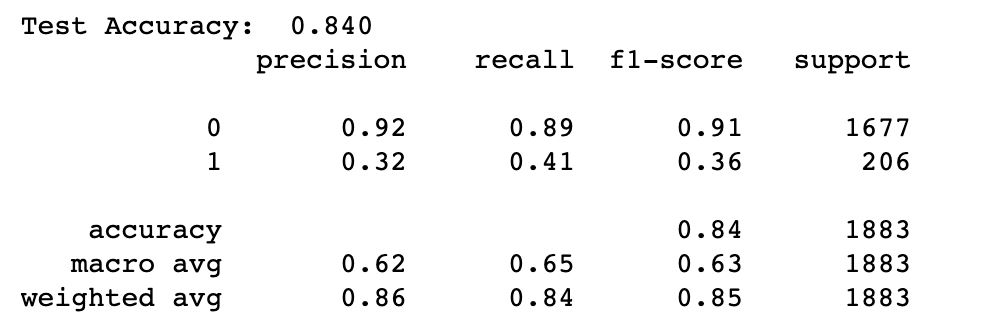